Import Matrix

In [ ]:
import random
import numpy as np
import sklearn.metrics 
from sklearn import datasets
from sklearn.model_selection import train_test_split, cross_val_score, ShuffleSplit, GridSearchCV
from sklearn import svm
from sklearn import tree
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        pass
        #print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    ax.set_ylim(len(classes)-0.5, -0.5)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

print("Libraries imported.")

Libraries imported.


Loading keras:

In [ ]:
import numpy as np
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator

print("Tensorflow version %s" %tf.__version__)
print("Keras version %s" %keras.__version__)

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Tensorflow version 2.4.0
Keras version 2.4.3
Found GPU at: /device:GPU:0


In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

datadir = '/content/drive/MyDrive/ML-HW2'
dataset = datadir+'/dataset/'
print(dataset)

Mounted at /content/drive
/content/drive/MyDrive/ML-HW2/dataset/


Now, we will unzip all the zip files in the dataset:

In [ ]:
!ls drive/MyDrive/ML-HW2
#!unzip "drive/MyDrive/ML-HW2/dataset/*.zip" -d drive/MyDrive/ML-HW2/dataset/imgs
# comment out previous two lines

dataset			   ML-HW2-CNN.ipynb	notebook-pdf-export.pdf
ensemble_cnn.h5		   ML-HW2.ipynb
ensemble-cnn-notebook.pdf  neki_novi_klinci.h5


First, we have to prepare the dataset by dividing training and testing parts:

In [ ]:
import os
import tensorflow as tf
import tensorflow_datasets as tfds

dataset_path = "/content/drive/MyDrive/ML-HW2/dataset/imgs"

batch_size = 32
img_height = 32
img_width = 32

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  dataset_path,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

n_train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y)) 

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  dataset_path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

n_val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y)) 

class_names = train_ds.class_names
print(class_names)


Found 8781 files belonging to 8 classes.
Using 7025 files for training.
Found 8781 files belonging to 8 classes.
Using 1756 files for validation.
['Carpet_Machine_Detergents', 'Melons', 'Seltzer_Water', 'food_tray', 'jarred_vegetables', 'potato_Crisps', 'soup_bowl', 'utensils']


Now, we will plot one image for each of the classes (to check if everything is ok):

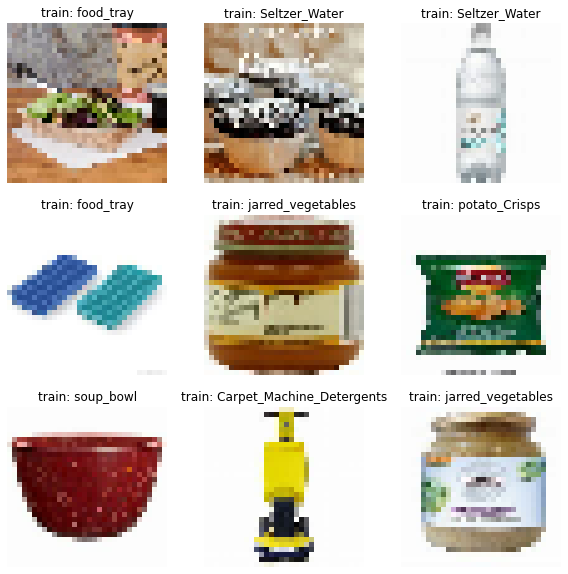

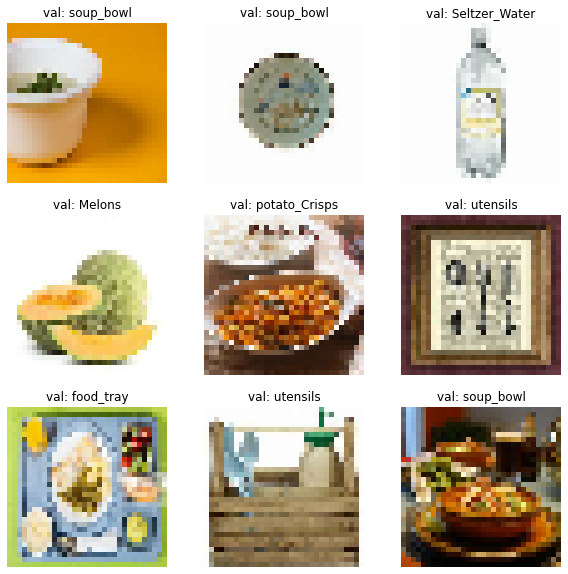

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title("train: "+class_names[labels[i]])
    plt.axis("off")

plt.figure(figsize=(10, 10))
for images, labels in val_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title("val: "+class_names[labels[i]])
    plt.axis("off")

Building a model

In [ ]:
from keras.models import Sequential
from tensorflow.keras import datasets, layers, models

AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

data_augmentation = Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(len(class_names))
])

model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 32, 32, 3)         0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 64)         

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

epochs = 20

history = model.fit(
    train_ds, epochs=epochs, validation_data=val_ds,
)

Epoch 1/20
220/220 [==============================] - 1485s 1s/step - loss: 1.9387 - accuracy: 0.2128 - val_loss: 1.7095 - val_accuracy: 0.3069
Epoch 2/20
220/220 [==============================] - 1s 4ms/step - loss: 1.6852 - accuracy: 0.3462 - val_loss: 1.5440 - val_accuracy: 0.4151
Epoch 3/20
220/220 [==============================] - 1s 5ms/step - loss: 1.5517 - accuracy: 0.4217 - val_loss: 1.4272 - val_accuracy: 0.4789
Epoch 4/20
220/220 [==============================] - 1s 5ms/step - loss: 1.4515 - accuracy: 0.4599 - val_loss: 1.3990 - val_accuracy: 0.4835
Epoch 5/20
220/220 [==============================] - 1s 5ms/step - loss: 1.4151 - accuracy: 0.4668 - val_loss: 1.3496 - val_accuracy: 0.5194
Epoch 6/20
220/220 [==============================] - 1s 4ms/step - loss: 1.3682 - accuracy: 0.4968 - val_loss: 1.4160 - val_accuracy: 0.4954
Epoch 7/20
220/220 [==============================] - 1s 4ms/step - loss: 1.3187 - accuracy: 0.5122 - val_loss: 1.3584 - val_accuracy: 0.5194
Epoc

220/220 [==============================] - 0s 2ms/step - loss: 1.0479 - accuracy: 0.6233
0.6233451962471008 0.5603644847869873


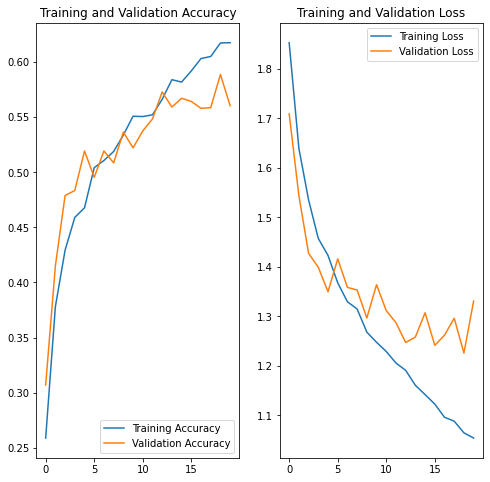

In [ ]:
test_loss, test_acc = model.evaluate(val_ds)
train_loss, train_acc = model.evaluate(train_ds)
print(train_acc, test_acc)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
model.save("/content/drive/MyDrive/ML-HW2/neki_novi_klinci.h5")

In [ ]:
load_file = True
model1 = model
if (load_file):
  model1.load_weights("/content/drive/MyDrive/ML-HW2/neki_novi_klinci.h5")
model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 32, 32, 3)         0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 64)         

Confusion matrix:

In [ ]:
pred = model1.predict(val_ds)

(1756, 8)
              precision    recall  f1-score   support

           0       0.51      0.85      0.64       181
           1       0.73      0.38      0.50       239
           2       0.52      0.58      0.54       226
           3       0.43      0.47      0.45       227
           4       0.48      0.69      0.57       239
           5       0.57      0.46      0.51       195
           6       0.87      0.54      0.67       202
           7       0.68      0.56      0.61       247

    accuracy                           0.56      1756
   macro avg       0.60      0.57      0.56      1756
weighted avg       0.60      0.56      0.56      1756

[[154  11  35  20  15   8  20  38]
 [  1  90   8   7   3   9   5   1]
 [  9  15 130  19  14  14  12  39]
 [  1  30   8 107  22  48  19  14]
 [  5  71  24  31 166  25  14   8]
 [  2  19   9  15  12  89   5   6]
 [  2   1   1  10   0   0 110   3]
 [  7   2  11  18   7   2  17 138]]


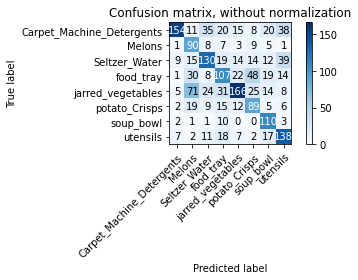

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

print(pred.shape)
predicted_categories = tf.argmax(pred, axis=1)
true_categories = tf.concat([y for x, y in val_ds], axis=0)

print(classification_report(true_categories, predicted_categories))
print(confusion_matrix(predicted_categories, true_categories))

plot_confusion_matrix(predicted_categories, true_categories, class_names)

